<a href="https://colab.research.google.com/github/rhn19/NN_TextClassification/blob/master/IMDB_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!wget "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

--2020-01-02 16:38:28--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  19.2MB/s    in 6.9s    

2020-01-02 16:38:35 (11.6 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



In [0]:
!tar xzf aclImdb_v1.tar.gz

In [0]:
import os
import re
import time
from collections import Counter
from itertools import chain

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pack_padded_sequence

DEVICE = torch.device("cuda:0")
### x -> reviews, y -> sentiments

In [0]:
def data_from_file(train_or_test_dir):
    reviews = []
    labels = []
    for sentiment in ["pos", "neg"]:
        dir = os.path.join(train_or_test_dir, sentiment)
        for file_name in os.listdir(dir):
            file = open(os.path.join(dir, file_name))
            reviews.append(file.read().lower())
            file.close()
            if sentiment == "pos":
                labels.append(1)
            else:
                labels.append(0)
    return reviews, labels

In [37]:
train_dir = "/content/aclImdb/train/"
test_dir = "/content/aclImdb/test/"
x_train ,y_train = data_from_file(train_dir)
x_test ,y_test = data_from_file(test_dir)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))
#print(x_train[:2])

25000 25000
25000 25000


In [0]:
def sent_to_wordlist(corpus):
    word_list = []
    #nobr = re.compile('\W*<br.*?>\W*', re.I)
    for sent in corpus:
        #sent = nobr.sub('', sent)
        sent = sent.replace('<br />', '')
        sent = sent.strip().split()
        word_list.append(sent)
    return word_list

In [0]:
def build_vocab(word_list, vocab_size=None):
    word_count = Counter(chain(*word_list))
    if vocab_size is None:
        vocab_size = len(word_count)
    #print(vocab_size)
    sorted_count = word_count.most_common(vocab_size)
    word2idx = {w:i+1 for i, (w, _) in enumerate(sorted_count)}
    return word2idx

In [0]:
def words_to_int(word_list, word2idx):
    int_list = []
    for sent in word_list:
        sent = [word2idx[w] for w in sent]
        int_list.append(sent)
    return int_list

In [41]:
x_train_word = sent_to_wordlist(x_train)
x_test_word = sent_to_wordlist(x_test)
#all_list = x_train_word + x_test_word
#print(len(all_list))
word2idx = build_vocab(x_train_word + x_test_word)
print(len(word2idx))

x_train_int = words_to_int(x_train_word , word2idx)
x_test_int = words_to_int(x_test_word , word2idx)
print(len(x_train_int), len(x_test_int))

x_train_len = [len(s) for s in x_train_int]
x_test_len = [len(s) for s in x_test_int]
print(len(x_train_len), len(x_test_len))

422521
25000 25000
25000 25000


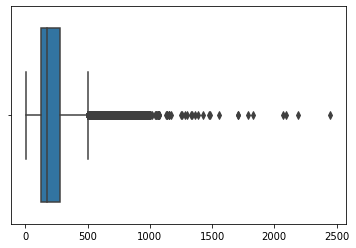

In [42]:
#analyze & remove outliers
sns.boxplot(x=x_train_len + x_test_len)

In [43]:
LIMIT = 500
x_train_int = [x_train_int[i] for i, len in enumerate(x_train_len) if len<LIMIT]
x_test_int = [x_test_int[i] for i, len in enumerate(x_test_len) if len<LIMIT]
y_train = [y_train[i] for i, len in enumerate(x_train_len) if len<LIMIT]
y_test = [y_test[i] for i, len in enumerate(x_test_len) if len<LIMIT]
print(len(x_train_int), len(x_test_int))
print(len(y_train), len(y_test))

x_train_len = [len(s) for s in x_train_int]
x_test_len = [len(s) for s in x_test_int]
print(len(x_train_len), len(x_test_len))

23070 23182
23070 23182
23070 23182


In [0]:
def pad_sequences(int_list, LIMIT, pad_token=0):
    padded_list = []
    for sent in int_list:
        sent = sent + [pad_token] * (LIMIT - len(sent))
        padded_list.append(sent)
    return padded_list

In [45]:
x_train_padded = pad_sequences(x_train_int, LIMIT)
x_test_padded = pad_sequences(x_test_int, LIMIT)
print(len(x_train_padded), len(x_test_padded))
#print(x_train_padded[1])
#t_len = [len(s) for s in x_train_padded]
#print(t_len[:10])
#print(x_train_len[1])

23070 23182


In [46]:
#validation split
VAL_SPLIT_RATIO = 0.5
split_len = int(len(x_test_padded) * VAL_SPLIT_RATIO)
x_val, x_test = x_test_padded[:split_len:], x_test_padded[split_len:]
print(len(x_val), len(x_test))
split_len = int(len(y_test) * VAL_SPLIT_RATIO)
y_val, y_test = y_test[:split_len], y_test[split_len:]
print(len(y_val), len(y_test))

split_len = int(len(x_test_len) * VAL_SPLIT_RATIO)
val_len, test_len = x_test_len[:split_len], x_test_len[split_len:]
print(len(val_len), len(test_len))

11591 11591
11591 11591
11591 11591


In [47]:
#sanity check for seq lengths
print(x_test_len[4], val_len[4])
print(x_test_len[11592], test_len[1])

437 437
268 268


In [0]:
#tensors & batches
train_data = TensorDataset(torch.tensor(x_train_padded, device=DEVICE), torch.tensor(y_train, device=DEVICE))
val_data = TensorDataset(torch.tensor(x_val, device=DEVICE), torch.tensor(y_val, device=DEVICE))
test_data = TensorDataset(torch.tensor(x_test, device=DEVICE), torch.tensor(y_test, device=DEVICE))

BATCH_SIZE = 50
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [49]:
#Sanity check for batches
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[     8,    357,      5,  ...,      0,      0,      0],
        [133851,     22,    188,  ...,      0,      0,      0],
        [     1,  33004,    125,  ...,      0,      0,      0],
        ...,
        [ 25679,  49807,      6,  ...,      0,      0,      0],
        [   236,      5,  23307,  ...,      0,      0,      0],
        [     8,    967,      1,  ...,      0,      0,      0]],
       device='cuda:0')

Sample label size:  torch.Size([50])
Sample label: 
 tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1], device='cuda:0')


In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_outputs, embedding_dim, bidirectional=False, num_layers=1, dropout=0.3):
        super(RNN, self).__init__()
        if bidirectional:
            self.dirn = 2
        else:
            self.dirn = 1

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.LSTM = nn.LSTM(embedding_dim, hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size * self.dirn, num_outputs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input:torch.Tensor)->torch.Tensor:
        #input = batch_size, seq_len
        embed_inp = self.embedding(input)   #batch_size, seq_len, embedding_dim
        embed_inp = embed_inp.permute(1,0,2)    #seq_len, batch_size, embedding_dim
        #figure out packing with dataloader- sending seq_lens of batch without another computation here
        #packed_inp = pack_padded_sequence(embed_inp)
        rnn , (hidden, cell) = self.LSTM(embed_inp) #rnn - seq_len, batch_size, num_dir * hidden_size
        #drop = self.dropout(rnn)
        #fc = self.fc(drop)  #seq_len, batch_size, num_outputs

        drop = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        fc = self.fc(drop)

        output = self.sigmoid(fc) #batch_size
        return output.squeeze()

In [0]:
#CONSTANTS & VARIABLES
VOCAB_SIZE = len(word2idx)
HIDDEN_SIZE = 256
NUM_OUTPUTS = 1
EMBEDDING_DIM = 400

In [66]:
model = RNN(VOCAB_SIZE, HIDDEN_SIZE, NUM_OUTPUTS, EMBEDDING_DIM, bidirectional=True)
print(model)
model =  model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(DEVICE)

RNN(
  (embedding): Embedding(422521, 400)
  (LSTM): LSTM(400, 256, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [0]:
def accuracy(y_pred, y):
    rounded_pred = torch.round(y_pred)
    correct = (rounded_pred == y).float()   #float for division
    return correct.sum()/len(correct)

In [0]:
def train(model, optimizer, criterion, train_loader):
    epoch_loss = 0
    epoch_acc = 0
    size = len(train_loader)
    train_iter = iter(train_loader)
    model.train()

    for x_batch, y_batch in train_iter:
        optimizer.zero_grad()
        preds = model(x_batch)
        y_batch = y_batch.type_as(preds)
        loss = criterion(preds, y_batch)
        acc = accuracy(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += loss.item()

    return epoch_loss/size, epoch_acc/size

In [0]:
def evaluate(model, criterion, val_loader):
    epoch_loss = 0
    epoch_acc = 0
    size = len(train_loader)
    val_iter = iter(val_loader)
    model.eval()

    with torch.no_grad():
        for x_batch, y_batch in val_iter:
            preds = model(x_batch)
            y_batch = y_batch.type_as(preds)
            loss = criterion(preds, y_batch)
            acc = accuracy(preds, y_batch)
            epoch_loss += loss.item()
            epoch_acc += loss.item()

    return epoch_loss/size, epoch_acc/size

In [71]:
NUM_EPOCHS = 20
valid_loss = float('inf')
for epoch in range(NUM_EPOCHS):
    start = time.time()
    train_loss, train_acc = train(model, optimizer, criterion, train_loader)
    eval_loss, eval_acc = evaluate(model, criterion, val_loader)
    end = time.time()

    if eval_loss < valid_loss:
        valid_loss = eval_loss
        torch.save(model.state_dict(), 'imdb_best')

    print("EPOCH: ", epoch)
    print("TIME: ", end-start)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {eval_loss:.3f} |  Val. Acc: {eval_acc*100:.2f}%')

EPOCH:  0
TIME:  111.05995297431946
	Train Loss: 0.646 | Train Acc: 64.62%
	 Val. Loss: 0.265 |  Val. Acc: 26.53%
EPOCH:  1
TIME:  111.62068390846252
	Train Loss: 0.640 | Train Acc: 64.00%
	 Val. Loss: 0.247 |  Val. Acc: 24.69%
EPOCH:  2
TIME:  111.61542129516602
	Train Loss: 0.605 | Train Acc: 60.47%
	 Val. Loss: 0.338 |  Val. Acc: 33.76%
EPOCH:  3
TIME:  111.77062201499939
	Train Loss: 0.642 | Train Acc: 64.17%
	 Val. Loss: 0.200 |  Val. Acc: 20.03%
EPOCH:  4
TIME:  111.90655493736267
	Train Loss: 0.577 | Train Acc: 57.70%
	 Val. Loss: 0.214 |  Val. Acc: 21.40%


KeyboardInterrupt: ignored

In [73]:
model.load_state_dict(torch.load('imdb_best'))
test_loss, test_acc = evaluate(model, criterion, test_loader)
print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

RuntimeError: ignored